# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# metadata
print(auto_mpg.metadata)

# variable information
print(auto_mpg.variables)


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [ ]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [ ]:
X.describe()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,193.425879,5.454774,104.469388,2970.424623,15.568090,76.010050,1.572864
std,104.269838,1.701004,38.491160,846.841774,2.757689,3.697627,0.802055
min,68.000000,3.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,104.250000,4.000000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,148.500000,4.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,262.000000,8.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,455.000000,8.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [ ]:
y.describe()

,mpg
count,398.000000
mean,23.514573
std,7.815984
min,9.000000
25%,17.500000
50%,23.000000
75%,29.000000
max,46.600000


En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

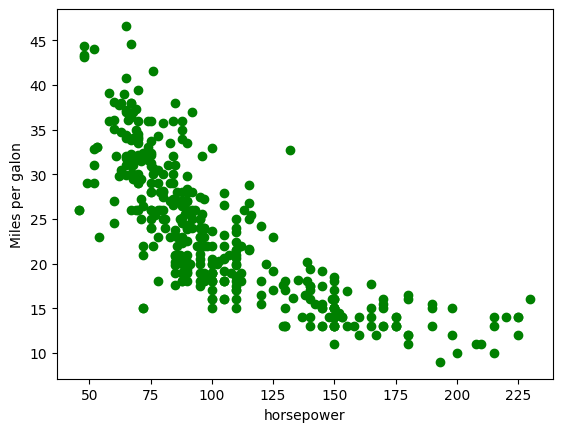

In [ ]:
import matplotlib.pyplot as plt

def visualiza(df, y, nombre_columna):
  # TODO dibuja la gráfica
  plt.scatter(df[nombre_columna], y, color = 'g')
  plt.xlabel(nombre_columna)
  plt.ylabel('Miles per galon')


visualiza(X, y, 'horsepower')

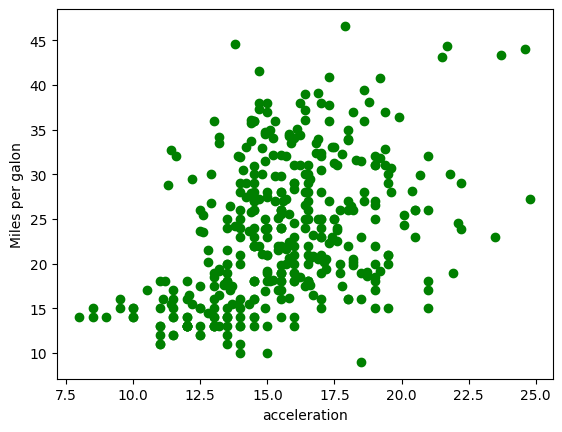

In [ ]:
visualiza(X, y, 'acceleration')

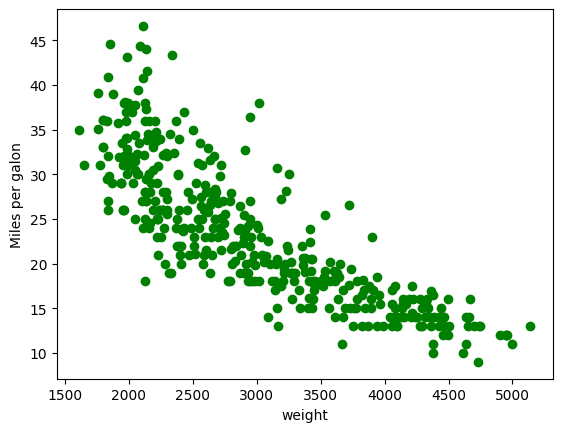

In [ ]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, lo mostramos por pantalla y salimos de la función. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [ ]:
X_weight = X[['weight']] #X['weight'].to_frame()
print(X_weight.shape)
print(X_weight.size)
print(len(X_weight))

(398, 1)
398
398


In [ ]:
import numpy as np

ones = np.ones((X_weight.size,1))
print(ones.shape)
Xweight_b = np.hstack((ones, X_weight))
print(Xweight_b.shape)

(398, 1)
(398, 2)


In [ ]:
y.shape

(398, 1)

In [ ]:
import numpy as np

def pesos_ols(X, y):
    # Implementa la fórmula matricial

    # TODO 1 Comprueba que las dimensiones son adecuadas

  if X.T.shape[1] == y.shape[0]:
    # TODO 2 Prepara la matriz X para que tenga la forma adecuada para aplicar la fórmula

    ones = np.ones((len(X),1))
    X_b = np.hstack((ones, X))

    # TODO 3 Calcula los pesos

    # W =(X^{T}X)^{-1}X^{T}y
    # W = np.dot(np.dot(np.linalg.inv(np.dot(X_b.T, X_b)), X_b.T), y)
    W = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

  else:
    print('Las dimensiones no son adecuadas')
    W = np.array(0)

  return W

In [ ]:
# Arrays de prueba!! No son dataset reales y no hace falta que los dibujemos
X_prueba = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077],
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y_prueba = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])

print(X_prueba.T.shape)
print(y_prueba.shape)
pesos_ols(X_prueba, y_prueba)

(10, 2)
(10,)
Las dimensiones no son adecuadas


array(0)

In [ ]:
X_prueba = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077],
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]]).reshape(10,2)
y_prueba = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])

print(X_prueba.T.shape)
print(y_prueba.shape)
print(X_prueba.size)
print(len(X_prueba))
pesos_ols(X_prueba, y_prueba)

(2, 10)
(10,)
20
10


array([ 1.98968523e+05,  7.36278026e+01, -8.63759760e+01])

Hasta aquí hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10, pero aún no lo hemos probado con ningún dataset real.

### 1.3 Prueba del modelo en los datos de consumo de coches

Ahora sí, ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

In [ ]:
# TODO Aplica el modelo y dibuja la recta junto con los datos
X_weight_np = X[['weight']].to_numpy()
y_np = y.to_numpy()
W_weight = pesos_ols(X_weight_np, y_np)
print(W_weight)

[[ 4.63173644e+01]
 [-7.67661006e-03]]


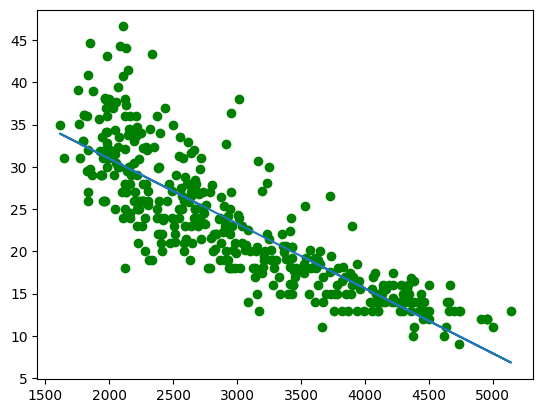

In [ ]:
y_recta = W_weight[0] + W_weight[1]*X_weight_np
plt.scatter(X_weight_np, y_np, color = 'g')
plt.plot(X_weight_np, y_recta)

In [ ]:
print(X_weight_np.shape)
print(X_weight_np.size)
print(len(X_weight_np))
print(X_weight_np.ndim)

(398, 1)
398
398
2


In [ ]:
print(W_weight.size)
print(W_weight.shape)
print(W_weight.ndim)
print()
for i in range(1,W_weight.size):
  print(i)

2
(2, 1)
2

1


In [ ]:
def visualize_lr(X, y, W):
  # TODO dibuja la gráfica
  y_recta = W[0]
  for i in range(1, W.size):
    y_recta = y_recta + W[i]*X

  plt.scatter(X, y, color = 'g')
  plt.plot(X, y_recta)
  #plt.xlabel('Weight')
  #plt.ylabel('Miles per galon')

[[4.969793  ]
 [1.19120453]]


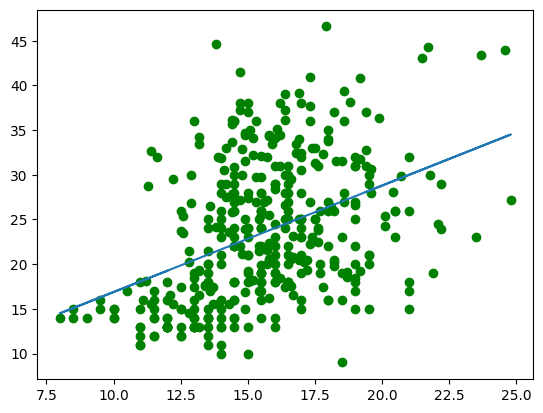

In [ ]:
X_acceleration_np = X[['acceleration']].to_numpy()
W_acceleration = pesos_ols(X_acceleration_np, y_np)
print(W_acceleration)
visualize_lr(X_acceleration_np,y_np, W_acceleration)

[[ 4.63173644e+01]
 [-7.67661006e-03]]


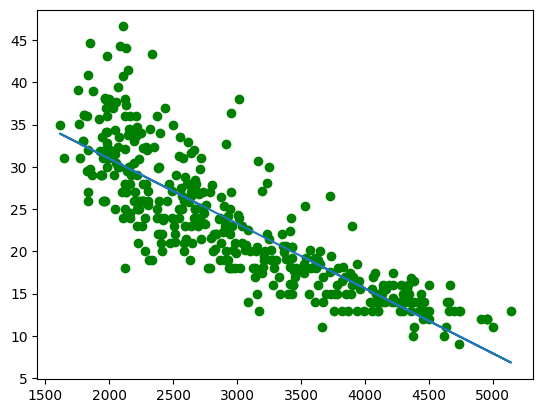

In [ ]:
X_weight_np = X[['weight']].to_numpy()
W_weight = pesos_ols(X_weight_np, y_np)
print(W_weight)
visualize_lr(X_weight_np, y_np, W_weight)

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [ ]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features
y = auto_mpg.data.targets

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn (solo hay que ver si coincide o no para saber si te has equivocado en algún punto). Si coincide, ¡enhorabuena! Ya sabes implementar tu primer modelo de Machine Learning desde la base.

## 2. Optimización con descenso del gradiente

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [ ]:
print(X_weight_np.shape)
print(X_weight_np.size)
print(len(X_weight_np))
print(X_weight_np.ndim)
print()

ones = np.ones((len(X_weight_np),1))
X_weight_np_b = np.hstack((ones, X_weight_np))

print(X_weight_np_b.shape)
print(X_weight_np_b.shape[1])
print(X_weight_np_b.size)
print(len(X_weight_np_b))
print(X_weight_np_b.ndim)

(398, 1)
398
398
2

(398, 2)
2
796
398
2


In [ ]:
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta):
  w_est = np.array(w0)
  RSS_prev = 0
  i=0

  # TODO 1 Añade la columna de 1s
  ones = np.ones((len(X),1))
  X_b = np.hstack((ones, X))

  # TODO 2 Haz un bucle para las iteraciones
  for i in range(n_iter):

    y_est = X_b @ w_est
    grad = X_b.T @ (y_est - y)
    w_est = w_est - eta*grad

    RSS = 0.5*np.sum((y-y_est)**2)
    if i >= 0 and abs(RSS_prev - RSS) < 1e-6:
      break
    RSS_prev = RSS

  return i+1, RSS, w_est

w0 = np.random.rand(2).reshape(2,1)
print(w0)

i, RSS, w_est = gradient_descent(X_weight_np, y_np, w0, 200000, 1e-10)
print('iteracion: ', i)
print('RSS = ', RSS)
print('w_est = ', w_est)


[[0.88535424]
 [0.84031716]]
iteracion:  200000
RSS =  34504.28569142296
w_est =  [[0.91220697]
 [0.00646281]]


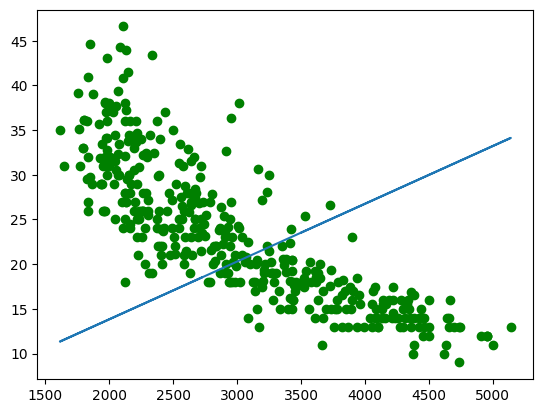

In [ ]:
visualize_lr(X_weight_np, y_np, w_est)

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



El metodo de minimos cuadrados encuentra el resultado en una iteracion, pero el costo computacional es muy alto ya que requiere de calcular la inversa. Por otro lado, el metodo descenso del gradiente requiere de estar jugando con las variables de eta y n_iter para llegar al resultado. En el caso especifico de la practica el valor de eta es extremadamente sensible, solo he podido hacer que converja con eta = 1e-10 (si cambio este valor, RSS explota) y la variable n_iter no aparece ayudar ya que lo he llevado a 200000 y no parece moverse mucho del punto de inicio (w0). Despues de leer sobre este metodo, he visto la importancia de la normalizacion de los datos de entrada, la exploracion de otras funciones de costo (cambiar de RSS a MSE, por ejemplo), asi como el calculo de una eta_max (para tener una mejor orientacion de este valor).

### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

[[-0.00037487]
 [ 0.00303775]]
iteracion:  10
RSS =  3737.4070072089944
w_est =  [[23.51457109]
 [-6.49270153]]


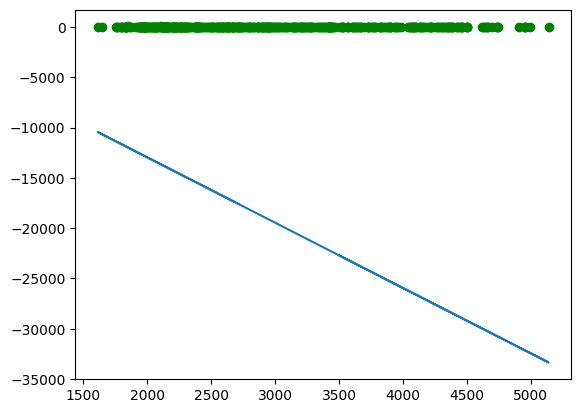

In [ ]:
# TODO Aplica el modelo y dibuja la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalamos la variable x

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

X_gd = (X_np - X_np.mean()) / X_np.std()
y_gd = y_np

# TODO 1 Punto inicial y learning rate
w0_gd = np.random.randn(2,1) * 0.01 #Normalizacion de w0
print(w0_gd)

eta = 3e-3 #Ver el ultimo apartado llamado Calculo de eta_max, eta y eta_safe

# TODO 2 Aplicamos el algoritmo
i, RSS, w_est = gradient_descent(X_gd, y_gd, w0_gd, 25, eta)
print('iteracion: ', i)
print('RSS = ', RSS)
print('w_est = ', w_est)

# Límites de los ejes
x_max = np.max(X_gd) + 1
x_min = np.min(X_gd) -1


# TODO 3 Dibuja la gráfica conjunta de la recta y los puntos (escalados)
visualize_lr(X_weight_np, y_np, w_est)

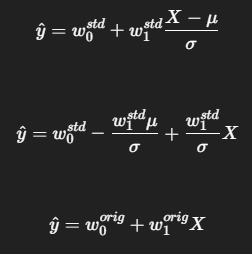

In [ ]:
w0_gd = w_est[0, 0]
w1_gd = w_est[1, 0]

w1_orig = w1_gd / X_np.std()
w0_orig = w0_gd - (w1_gd * X_np.mean() / X_np.std())

w_orig = np.array([[w0_orig],
                   [w1_orig]])

print("w desestandarizado:", w_orig)

w desestandarizado: [[ 4.63173609e+01]
 [-7.67660948e-03]]


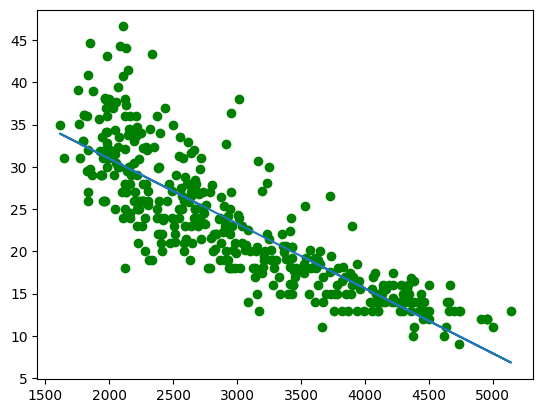

In [ ]:
# TODO 3 Dibuja la gráfica conjunta de la recta y los puntos (escalados)
visualize_lr(X_weight_np, y_np, w_orig)

In [ ]:
#Calculo de eta_max, eta y eta_safe

ones = np.ones((len(X_gd),1))
X_gd_b = np.hstack((ones, X_gd))
H_gd = X_gd_b.T @ X_gd_b

L = np.linalg.eigvalsh(H_gd).max()
eta_max = 2.0 / L
eta = 1.0 / L
eta_safe = 0.1*eta_max
print("L:", L, "eta_max:", eta_max, "eta:", eta, "eta_safe:", eta_safe)

L: 398.00000000000006 eta_max: 0.005025125628140703 eta: 0.0025125628140703514 eta_safe: 0.0005025125628140703
